# About
* My first Kaggle notebook
* Feature engineering with pandas
* Binary classification Neural Network with tensorflow2

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv


In [2]:
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.1.0


In [4]:
# Use some functions from tensorflow_docs
!pip install -q git+https://github.com/tensorflow/docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

# Dataset
* Titanic

## Get the data
* First import from csv

In [5]:
#import pandas as pd
gender_submission = pd.read_csv("../input/titanic/gender_submission.csv")
raw_test = pd.read_csv("../input/titanic/test.csv")
raw_dataset = pd.read_csv("../input/titanic/train.csv")

dataset = raw_dataset.copy()
quizset = raw_test.copy()
provset = dataset.append(pd.concat([quizset,gender_submission['Survived']],axis=1,sort=False)).reset_index(drop=True)
datacount = len(dataset)

print('dataset:', len(dataset))  # DataFrame of training and validation
print('quizset:', len(quizset))  # DataFrame of quiz(Survived columns not exist)
print('provset: ',len(provset))  # DataFrame of provisioning (Survived columns NOT valid)

dataset: 891
quizset: 418
provset:  1309


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [6]:
provset.dtypes

Age            float64
Cabin           object
Embarked        object
Fare           float64
Name            object
Parch            int64
PassengerId      int64
Pclass           int64
Sex             object
SibSp            int64
Survived         int64
Ticket          object
dtype: object

## Clean the data
* The datase contains a few unknown values.

In [7]:
provset.isna().sum()

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived          0
Ticket            0
dtype: int64

In [8]:
# Many data is missing in Age but Name's title(Mr,Mrs,Master,etc..) will fill this gap a little.
provset['Title'] = provset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Titles seem to determine their fate
pd.crosstab(provset['Title'],provset['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,4
Countess,1,0
Don,0,1
Dona,1,0
Dr,1,7
Jonkheer,0,1
Lady,1,0
Major,0,2


In [9]:
# Age mean,median per Title
age_mean = provset.groupby(['Title'])['Age'].mean()
age_median = provset.groupby(['Title'])['Age'].median()
age_std = provset.groupby(['Title'])['Age'].std()
pd.DataFrame([age_mean,age_median,age_std],index=['mean','median','std'])


Title,Capt,Col,Countess,Don,Dona,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
mean,70.0,54.000000,33.0,40.0,39.0,43.571429,38.0,48.0,48.500000,5.482642,21.774238,24.0,24.0,32.252151,36.994118,28.0,41.250000,49.0
median,70.0,54.500000,33.0,40.0,39.0,49.000000,38.0,48.0,48.500000,4.000000,22.000000,24.0,24.0,29.000000,35.500000,28.0,41.500000,49.0
std,NaN,5.477226,NaN,NaN,NaN,11.731115,NaN,NaN,4.949747,4.161554,12.249077,0.0,NaN,12.422089,12.901767,NaN,12.020815,NaN


In [10]:
# Missing Data fill with median per Title
for title,subset in provset.groupby(['Title']):
    provset.loc[provset['Age'].isna() & (provset['Title'] == title), 'Age'] = age_median[title]
provset            

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0,A/5 21171,Mr
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1,PC 17599,Mrs
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1,STON/O2. 3101282,Miss
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1,113803,Mrs
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0,373450,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,29.0,NaN,S,8.0500,"Spector, Mr. Woolf",0,1305,3,male,0,0,A.5. 3236,Mr
1305,39.0,C105,C,108.9000,"Oliva y Ocana, Dona. Fermina",0,1306,1,female,0,1,PC 17758,Dona
1306,38.5,NaN,S,7.2500,"Saether, Mr. Simon Sivertsen",0,1307,3,male,0,0,SOTON/O.Q. 3101262,Mr
1307,29.0,NaN,S,8.0500,"Ware, Mr. Frederick",0,1308,3,male,0,0,359309,Mr


In [11]:
# Cabin to Deck
provset['Deck'] = provset['Cabin'].str.extract('([A-Z])')

# Deck and Survived
pd.crosstab(provset['Deck'],provset['Pclass'])

Pclass,1,2,3
Deck,,,
A,22,0,0
B,65,0,0
C,94,0,0
D,40,6,0
E,34,4,3
F,0,13,8
G,0,0,5
T,1,0,0


In [12]:
# fill na class
provset.loc[provset['Embarked'].isna(), 'Embarked'] = 'O' # other class
#provset.loc[provset['Cabin'].isna(), 'Cabin'] = 'O' # other class
provset.loc[provset['Deck'].isna(), 'Deck'] = 'O' # other class

In [13]:
# add family_size
provset['FamilySize'] = provset['Parch'] + provset['SibSp'] + 1

# and add IsAlone
provset['IsAlone'] = 0
provset.loc[(provset['FamilySize'] == 1), 'IsAlone'] = 1

# https://stackoverflow.com/questions/30211923/what-is-the-difference-between-pandas-qcut-and-pandas-cut
# add FareBin (qcut)
provset['FareBin'] = pd.qcut(provset['Fare'], 4)
# AgeBin (cut)
provset['AgeBin'] = pd.cut(provset['Age'].astype(int), 5)

provset

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Deck,FamilySize,IsAlone,FareBin,AgeBin
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0,A/5 21171,Mr,O,2,0,"(-0.001, 7.896]","(16.0, 32.0]"
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1,PC 17599,Mrs,C,2,0,"(31.275, 512.329]","(32.0, 48.0]"
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1,STON/O2. 3101282,Miss,O,1,1,"(7.896, 14.454]","(16.0, 32.0]"
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1,113803,Mrs,C,2,0,"(31.275, 512.329]","(32.0, 48.0]"
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0,373450,Mr,O,1,1,"(7.896, 14.454]","(32.0, 48.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,29.0,NaN,S,8.0500,"Spector, Mr. Woolf",0,1305,3,male,0,0,A.5. 3236,Mr,O,1,1,"(7.896, 14.454]","(16.0, 32.0]"
1305,39.0,C105,C,108.9000,"Oliva y Ocana, Dona. Fermina",0,1306,1,female,0,1,PC 17758,Dona,C,1,1,"(31.275, 512.329]","(32.0, 48.0]"
1306,38.5,NaN,S,7.2500,"Saether, Mr. Simon Sivertsen",0,1307,3,male,0,0,SOTON/O.Q. 3101262,Mr,O,1,1,"(-0.001, 7.896]","(32.0, 48.0]"
1307,29.0,NaN,S,8.0500,"Ware, Mr. Frederick",0,1308,3,male,0,0,359309,Mr,O,1,1,"(7.896, 14.454]","(16.0, 32.0]"


In [14]:
# drop unreasonable columns
#provset = provset.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
provset.tail()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Deck,FamilySize,IsAlone,FareBin,AgeBin
1304,29.0,NaN,S,8.0500,"Spector, Mr. Woolf",0,1305,3,male,0,0,A.5. 3236,Mr,O,1,1,"(7.896, 14.454]","(16.0, 32.0]"
1305,39.0,C105,C,108.9000,"Oliva y Ocana, Dona. Fermina",0,1306,1,female,0,1,PC 17758,Dona,C,1,1,"(31.275, 512.329]","(32.0, 48.0]"
1306,38.5,NaN,S,7.2500,"Saether, Mr. Simon Sivertsen",0,1307,3,male,0,0,SOTON/O.Q. 3101262,Mr,O,1,1,"(-0.001, 7.896]","(32.0, 48.0]"
1307,29.0,NaN,S,8.0500,"Ware, Mr. Frederick",0,1308,3,male,0,0,359309,Mr,O,1,1,"(7.896, 14.454]","(16.0, 32.0]"
1308,4.0,NaN,C,22.3583,"Peter, Master. Michael J",1,1309,3,male,1,0,2668,Master,O,3,0,"(14.454, 31.275]","(-0.08, 16.0]"


# Split provset to dataset

In [15]:
dataset = provset[:datacount]
temp = dataset.copy()
dataset_labels = temp.pop('Survived')


## (Split the data into train and test)
* Split data into train/test in Hold-out Validation
* But we don't split for Cross Validation

## Inspect the data

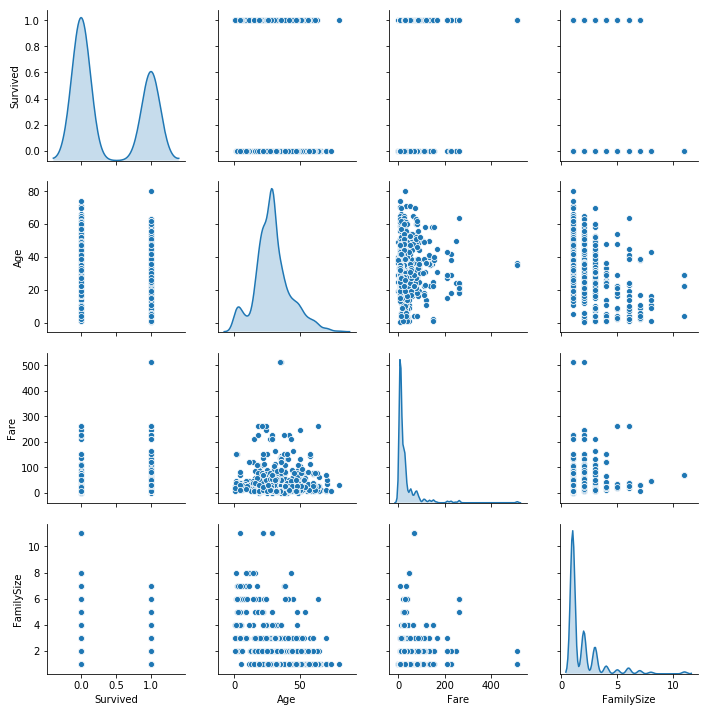

In [16]:
sns.pairplot(dataset[["Survived", "Age", "Fare", "FamilySize"]], diag_kind="kde")

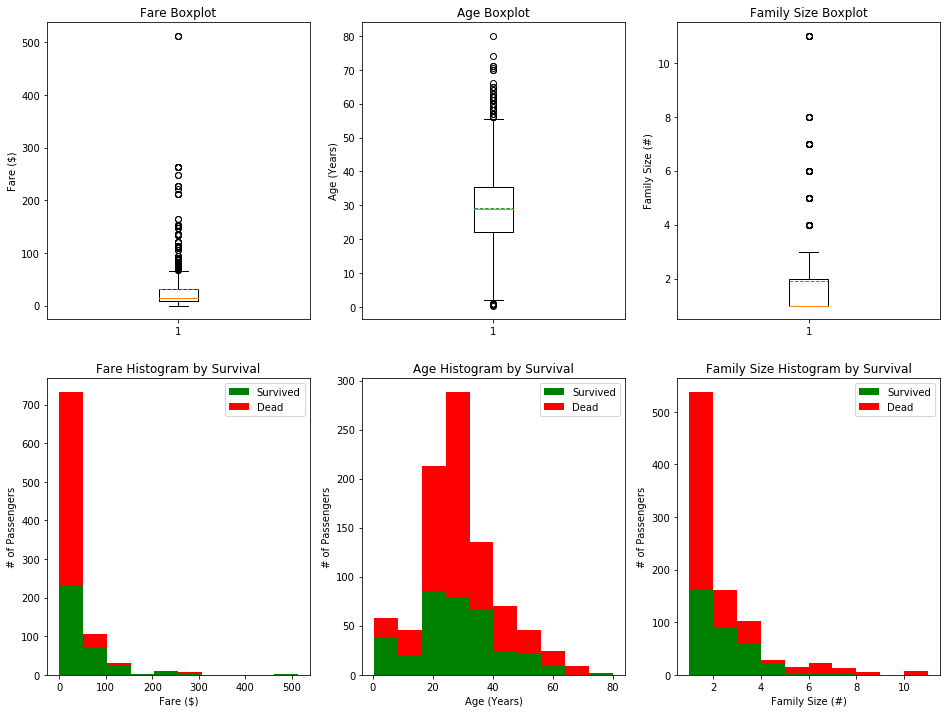

In [17]:
#graph distribution of quantitative data
plt.figure(figsize=[16,12])

plt.subplot(231)
plt.boxplot(x=dataset['Fare'], showmeans = True, meanline = True)
plt.title('Fare Boxplot')
plt.ylabel('Fare ($)')

plt.subplot(232)
plt.boxplot(dataset['Age'], showmeans = True, meanline = True)
plt.title('Age Boxplot')
plt.ylabel('Age (Years)')

plt.subplot(233)
plt.boxplot(dataset['FamilySize'], showmeans = True, meanline = True)
plt.title('Family Size Boxplot')
plt.ylabel('Family Size (#)')

plt.subplot(234)
plt.hist(x = [dataset[dataset['Survived']==1]['Fare'], dataset[dataset['Survived']==0]['Fare']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Fare Histogram by Survival')
plt.xlabel('Fare ($)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(235)
plt.hist(x = [dataset[dataset['Survived']==1]['Age'], dataset[dataset['Survived']==0]['Age']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Age Histogram by Survival')
plt.xlabel('Age (Years)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(236)
plt.hist(x = [dataset[dataset['Survived']==1]['FamilySize'], dataset[dataset['Survived']==0]['FamilySize']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Family Size Histogram by Survival')
plt.xlabel('Family Size (#)')
plt.ylabel('# of Passengers')
plt.legend()

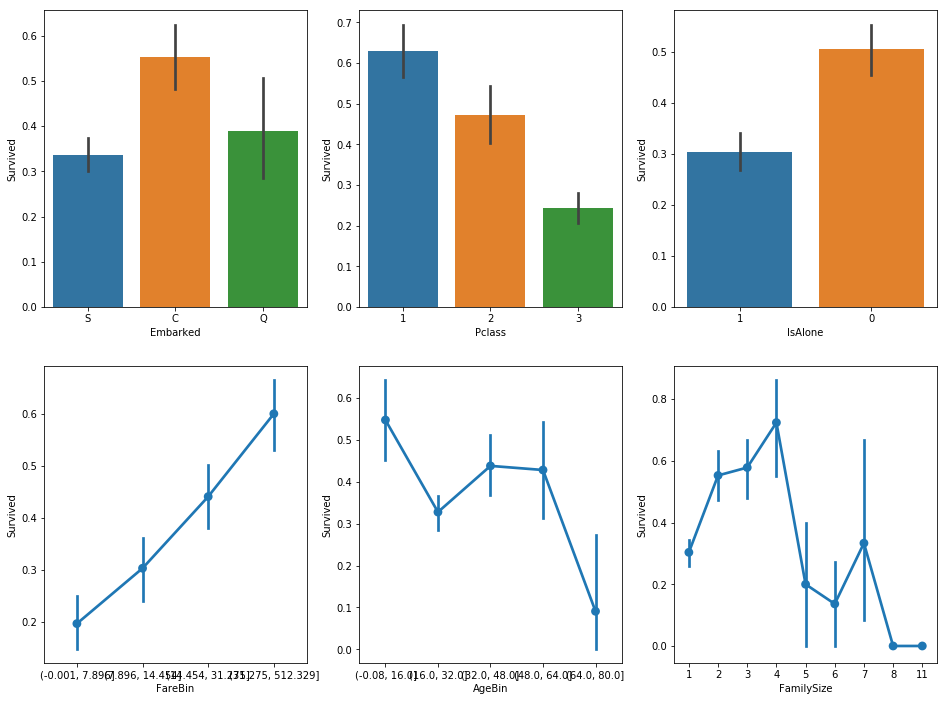

In [18]:
#graph individual features by survival
fig, saxis = plt.subplots(2, 3,figsize=(16,12))

sns.barplot(x = 'Embarked', y = 'Survived', order=['S','C','Q'], data=dataset, ax = saxis[0,0])
sns.barplot(x = 'Pclass', y = 'Survived', order=[1,2,3], data=dataset, ax = saxis[0,1])
sns.barplot(x = 'IsAlone', y = 'Survived', order=[1,0], data=dataset, ax = saxis[0,2])

sns.pointplot(x = 'FareBin', y = 'Survived',  data=dataset, ax = saxis[1,0])
sns.pointplot(x = 'AgeBin', y = 'Survived',  data=dataset, ax = saxis[1,1])
sns.pointplot(x = 'FamilySize', y = 'Survived', data=dataset, ax = saxis[1,2])

# Prepare data

## One hot encoding

In [19]:
# one hot encoding
provset = pd.get_dummies(provset, columns=['Sex','Embarked','Pclass','Title', 'Deck', 'FareBin', 'AgeBin'])


## Split the data into dataset(x,yhat) and quizset(x)
* dataset is provset so that Survived flag in the last of 418 is dummy

In [20]:
# dataset
dataset = provset[:datacount]
dataset_labels = dataset.pop('Survived')

# drop unreasonable columns
dataset_x = dataset.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

# quizset needs PassengerId
quizset = provset[datacount:].drop('Survived',axis=1)
quizset_x = quizset.drop(['Name', 'Ticket', 'Cabin'], axis=1)

## Normalize the data

In [21]:
NUMERICAL_COLUMNS = ['Age', 'Fare', 'Parch', 'SibSp', 'FamilySize']
provset_stats = provset[NUMERICAL_COLUMNS].describe().T
provset_stats

,count,mean,std,min,25%,50%,75%,max
Age,1309.0,29.432521,13.163767,0.17,22.0000,29.0000,35.500,80.0000
Fare,1308.0,33.295479,51.758668,0.00,7.8958,14.4542,31.275,512.3292
Parch,1309.0,0.385027,0.865560,0.00,0.0000,0.0000,0.000,9.0000
SibSp,1309.0,0.498854,1.041658,0.00,0.0000,0.0000,1.000,8.0000
FamilySize,1309.0,1.883881,1.583639,1.00,1.0000,1.0000,2.000,11.0000


In [22]:
dataset_x.loc[:,'Age']
#provset_stats.loc['Age','mean']
#provset_stats.loc['Age','std']

0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
886    27.0
887    19.0
888    22.0
889    26.0
890    32.0
Name: Age, Length: 891, dtype: float64

In [23]:
def norm(dataset_x):
    for col in NUMERICAL_COLUMNS:
        x = dataset_x.loc[:,col]
        mean = provset_stats.loc[col,'mean']
        std = provset_stats.loc[col,'std']
        dataset_x.loc[:,col] = (x - mean) / std
    return dataset_x
    
normed_dataset_x = norm(dataset_x)
normed_quizset_x = norm(quizset_x)
normed_dataset_x

,Age,Fare,Parch,SibSp,FamilySize,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_O,...,Deck_T,"FareBin_(-0.001, 7.896]","FareBin_(7.896, 14.454]","FareBin_(14.454, 31.275]","FareBin_(31.275, 512.329]","AgeBin_(-0.08, 16.0]","AgeBin_(16.0, 32.0]","AgeBin_(32.0, 48.0]","AgeBin_(48.0, 64.0]","AgeBin_(64.0, 80.0]"
0,-0.564620,-0.503210,-0.444829,0.481104,0.073324,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0
1,0.650838,0.733941,-0.444829,0.481104,0.073324,0,1,0,1,0,...,0,0,0,0,1,0,0,1,0,0
2,-0.260755,-0.490169,-0.444829,-0.478904,-0.558133,1,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0
3,0.422940,0.382632,-0.444829,0.481104,0.073324,0,1,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,0.422940,-0.487754,-0.444829,-0.478904,-0.558133,1,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,-0.184789,-0.392117,-0.444829,-0.478904,-0.558133,1,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0
887,-0.792518,-0.063670,-0.444829,-0.478904,-0.558133,1,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
888,-0.564620,-0.190219,1.865813,0.481104,1.336238,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
889,-0.260755,-0.063670,-0.444829,-0.478904,-0.558133,1,0,1,1,0,...,0,0,0,1,0,0,1,0,0,0


# The model
## build the model

In [24]:
def build_model(units=512, activation="relu", optimizer="adam", l2_param=0.001, dropout_rate=0.2, learning_rate=1e-05):
    model = keras.Sequential([
        layers.Dense(units,
                     kernel_regularizer=tf.keras.regularizers.l2(l2_param),
                     activation=activation, input_shape=[len(dataset_x.keys())]),
        layers.Dropout(dropout_rate),
        layers.Dense(units,
                     kernel_regularizer=tf.keras.regularizers.l2(l2_param),
                     activation=activation),
        layers.Dropout(dropout_rate),
        layers.Dense(units,
                     kernel_regularizer=tf.keras.regularizers.l2(l2_param),
                     activation=activation),
        layers.Dropout(dropout_rate),
        layers.Dense(1, activation='sigmoid')
    ])

    optimizer = tf.keras.optimizers.get(optimizer)
    optimizer.learning_rate=learning_rate

    model.compile(loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy', 'binary_crossentropy'])
    return model

model = build_model()

## Inspect the model

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               26624     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5

In [26]:
ex_batch = normed_dataset_x[:10]
ex_result = model.predict(ex_batch)
ex_result

array([[0.50276285],
       [0.48992962],
       [0.47647145],
       [0.49088764],
       [0.49877456],
       [0.49427092],
       [0.504551  ],
       [0.49748453],
       [0.48446164],
       [0.47444195]], dtype=float32)

# Hyperparameter tuning

## Train the model

In [27]:
EPOCHS = 600

history = model.fit(
  normed_dataset_x, dataset_labels,
  epochs=EPOCHS, validation_split = 0.25, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, accuracy:0.5299,  binary_crossentropy:0.6912,  loss:1.8074,  val_accuracy:0.6368,  val_binary_crossentropy:0.6791,  val_loss:1.7936,  
....................................................................................................
Epoch: 100, accuracy:0.8338,  binary_crossentropy:0.4132,  loss:1.2713,  val_accuracy:0.8655,  val_binary_crossentropy:0.3366,  val_loss:1.1937,  
....................................................................................................
Epoch: 200, accuracy:0.8428,  binary_crossentropy:0.3768,  loss:1.0617,  val_accuracy:0.8789,  val_binary_crossentropy:0.3310,  val_loss:1.0151,  
....................................................................................................
Epoch: 300, accuracy:0.8563,  binary_crossentropy:0.3563,  loss:0.9261,  val_accuracy:0.8789,  val_binary_crossentropy:0.3347,  val_loss:0.9040,  
....................................................................................................
Epoch: 40

In [28]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,binary_crossentropy,val_loss,val_accuracy,val_binary_crossentropy,epoch
595,0.693840,0.887725,0.292884,0.756641,0.856502,0.355873,595
596,0.703261,0.880240,0.302663,0.754795,0.860987,0.354391,596
597,0.703261,0.884731,0.303033,0.754609,0.856502,0.354574,597
598,0.699107,0.880240,0.299252,0.754385,0.860987,0.354719,598
599,0.692137,0.890719,0.292642,0.754306,0.860987,0.354996,599


In [29]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'Accuracy')

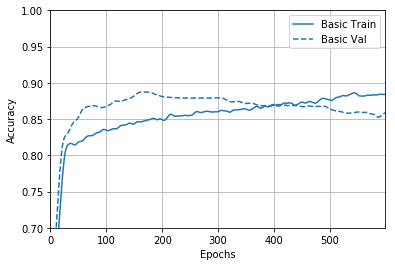

In [30]:
plotter.plot({'Basic': history}, metric = "accuracy")
plt.ylim([0.7, 1])
plt.ylabel('Accuracy')

Text(0, 0.5, 'Binary Crossentropy')

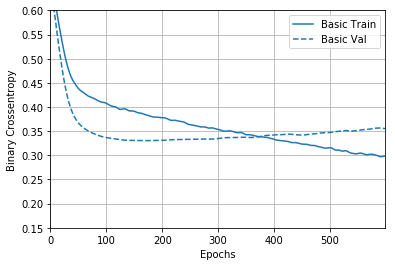

In [31]:
plotter.plot({'Basic': history}, metric = "binary_crossentropy")
plt.ylim([0.15, 0.6])
plt.ylabel('Binary Crossentropy')

In [32]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=60, restore_best_weights=True)

early_history = model.fit(normed_dataset_x, dataset_labels, 
                    epochs=EPOCHS, validation_split = 0.25, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, accuracy:0.5479,  binary_crossentropy:0.6900,  loss:1.8065,  val_accuracy:0.7489,  val_binary_crossentropy:0.6778,  val_loss:1.7927,  
....................................................................................................
Epoch: 100, accuracy:0.8338,  binary_crossentropy:0.4105,  loss:1.2704,  val_accuracy:0.8744,  val_binary_crossentropy:0.3396,  val_loss:1.1984,  
....................................................................................................
Epoch: 200, accuracy:0.8593,  binary_crossentropy:0.3777,  loss:1.0644,  val_accuracy:0.8744,  val_binary_crossentropy:0.3242,  val_loss:1.0102,  
....................................................................................................
Epoch: 300, accuracy:0.8623,  binary_crossentropy:0.3505,  loss:0.9226,  val_accuracy:0.8700,  val_binary_crossentropy:0.3221,  val_loss:0.8938,  
....................................................................................................
Epoch: 40

Text(0, 0.5, 'Binary Crossentropy')

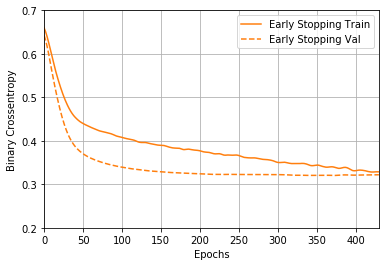

In [33]:
plotter.plot({'Early Stopping': early_history}, metric = "binary_crossentropy")
plt.ylim([0.2, 0.7])
plt.ylabel('Binary Crossentropy')

# Make predictions
## test with dataset

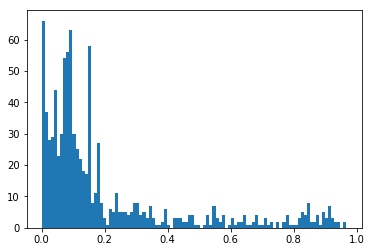

In [34]:
dataset_predictions = model.predict(normed_dataset_x).flatten()
error = dataset_predictions - dataset_labels

_ = plt.hist(abs(error),bins=100)
#_ = plt.scatter(dataset_predictions,dataset_labels, s=100, alpha=0.2)

# Quiz predictions

In [35]:
# quiz_data
quizset_x_copy = quizset_x.copy()
pid = quizset_x_copy.pop('PassengerId')

yhat = model.predict(quizset_x_copy)

submission = np.concatenate([[pid, yhat.flatten()]])
submission = pd.DataFrame(submission.T, columns=['PassengerId','Survived'])
submission.loc[:,'Survived'] = submission.loc[:,'Survived'].apply(lambda x: 1 if x > 0.5 else 0)
submission = submission.astype(np.int,copy=False)
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [36]:
!rm ./submission.csv
submission.to_csv('submission.csv',index=False)

rm: cannot remove './submission.csv': No such file or directory
